In [25]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import dicom
import os
import scipy.ndimage
import glob
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [26]:
INPUT_FOLDER = 'D:/Luna16/LIDC-IDRI/data/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [27]:
patients

['3000566-03192']

In [28]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [29]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    outside_image = image.min()
    image[image == outside_image] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [30]:
path = INPUT_FOLDER + patients[0]
slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path) if s.endswith('.dcm')]
slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
for s in slices:
        s.SliceThickness = slice_thickness

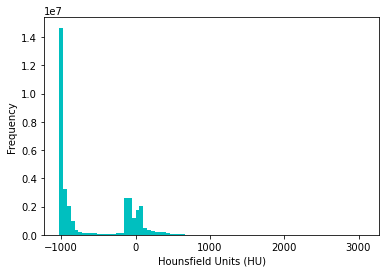

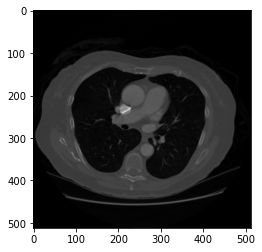

In [31]:
first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [33]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [34]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (133, 512, 512)
Shape after resampling	 (332, 360, 360)


In [41]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

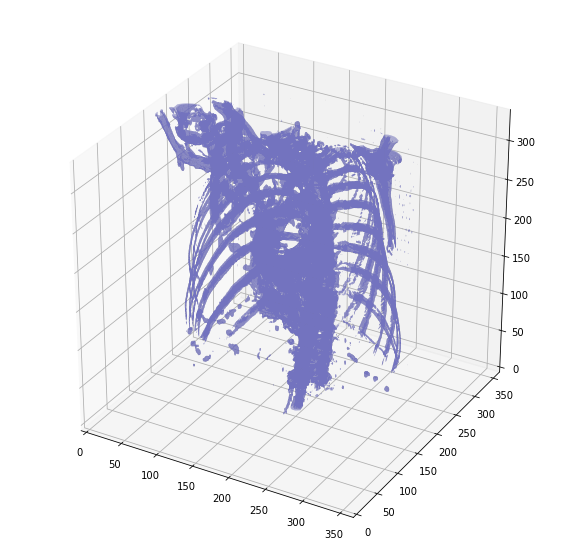

In [42]:
plot_3d(pix_resampled, 400)

In [16]:
[first_patient[0].SliceThickness]

['2.5']

In [17]:
np.array([first_patient[0].SliceThickness] + first_patient[0].PixelSpacing, dtype=np.float32)

array([2.5     , 0.703125, 0.703125], dtype=float32)

In [23]:
np.array([first_patient[0].SliceThickness] + first_patient[0].PixelSpacing)/[1,1,1]

array([2.5     , 0.703125, 0.703125])

In [20]:
[1]+[2,3]

[1, 2, 3]

In [50]:
np.unique(np.array([0,0,1,1,1,2,1,3,0,0,0,1,1,1,2,1,3,0,0,0,1,1,1,2,1,3,0]).reshape(3,3,3), return_counts=True)

(array([0, 1, 2, 3]), array([ 9, 12,  3,  3], dtype=int64))

In [49]:
np.array([0,0,1,1,1,2,1,3,0,0,0,1,1,1,2,1,3,0,0,0,1,1,1,2,1,3,0]).reshape(3,3,3)

array([[[0, 0, 1],
        [1, 1, 2],
        [1, 3, 0]],

       [[0, 0, 1],
        [1, 1, 2],
        [1, 3, 0]],

       [[0, 0, 1],
        [1, 1, 2],
        [1, 3, 0]]])